# HW 1 Part 2

## Visualize the optimization process

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
import pandas

In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

In [3]:
class NMISTNetwork3(nn.Module):
        """Third CNN for NMIST"""
        def __init__(self):
            super().__init__()
            self.seq = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 5),
            nn.Dropout(.25),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5),
            nn.Flatten(1), 
            nn.Linear(16384, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            )
        
        def forward(self, x):
              output = self.seq(x)
              return output

In [4]:
def nmist_train_loop(dataloader, model, loss_fn, optimize, epoch):
    """Training loop funciton for non-linear function"""
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)
        
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()

        loss.backward()
        optimize.step()
    train_loss /= num_batches
    correct /=size
    
    grad_all = 0
    
    for params in model.parameters():
        grad = 0.0
        if params.grad is not None:
            grad = (params.grad.cpu().data.numpy() ** 2).sum()
        grad_all +=grad
    
    grad_norm = grad_all ** 0.5
    
    weights = torch.Tensor().to(device)
    last_layer_wht = torch.Tensor().to(device)
    for name, params in model.named_parameters():
        if 'weight' in name:
            #print(name, len(params), params.shape)
            weights = torch.concat((weights, torch.nn.utils.parameters_to_vector(params).to(device)))
            last_layer_wht = torch.nn.utils.parameters_to_vector(params).to(device)

    return train_loss, correct, grad_all, weights, last_layer_wht
        
def nmist_val_loop(dataloader, model, loss_fn, epoch):
    """Eval loop function for non-linear function"""
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct

In [5]:
# nmist3 = NMISTNetwork3()
# nmist3.load_state_dict(torch.load('nmist3_weights.pth', weights_only=True))
df = pandas.DataFrame(columns=['epoch', 'training_event', 'weights'])

In [6]:
df = pandas.DataFrame(columns=['epoch', 'loss', 'accuracy', 'grad_norm'])

epoch_tracker = dict()
last_weight = dict()

for training_event in range(8):
    nmist3 = NMISTNetwork3()
    
    loss_fn = torch.nn.CrossEntropyLoss()
    
    lr = 1.5e-2
    batch_size=150
    max_epochs = 25
    
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    optimizer = torch.optim.SGD(nmist3.parameters(), lr=lr)

    
    for epoch in range(max_epochs):
        loss, accuracy, grad_norm, weights, last_layer_wht = nmist_train_loop(training_dl, nmist3, loss_fn, optimizer, epoch)
        if training_event ==0:
            row = pandas.DataFrame([[epoch, loss, accuracy, grad_norm]], columns=['epoch','loss','accuracy', 'grad_norm'])
            if df.empty:
                df = row
            else:
                df = pandas.concat([df, row], ignore_index=True)
        
        with torch.no_grad():
            if epoch%3==0:
                if epoch in epoch_tracker:
                    epoch_tracker[epoch] = torch.concat((epoch_tracker[epoch], weights.unsqueeze(-1).T))
                else:
                    epoch_tracker[epoch] = weights.unsqueeze(-1).T
                    
                if epoch in last_weight:
                    last_weight[epoch] = torch.concat((last_weight[epoch], last_layer_wht.unsqueeze(-1).T))
                else:
                    last_weight[epoch] = last_layer_wht.unsqueeze(-1).T
                
            display(f"Training event {training_event} Epoch {epoch}. Train loss: {loss}. Accuracy: {accuracy}. Grad_Norm: {grad_norm}.")
                                                   
        
    

'Training event 0 Epoch 0. Train loss: 0.7419928534701467. Accuracy: 0.7759. Grad_Norm: 4.93206262588501.'

'Training event 0 Epoch 1. Train loss: 0.20712201203219593. Accuracy: 0.9380333333333334. Grad_Norm: 5.9803876876831055.'

'Training event 1 Epoch 0. Train loss: 0.7143623260501772. Accuracy: 0.7861. Grad_Norm: 5.887648105621338.'

'Training event 1 Epoch 1. Train loss: 0.20152538392692804. Accuracy: 0.9406833333333333. Grad_Norm: 5.9297356605529785.'

'Training event 2 Epoch 0. Train loss: 0.7887015289813281. Accuracy: 0.7499666666666667. Grad_Norm: 4.7480034828186035.'

'Training event 2 Epoch 1. Train loss: 0.2207901593763381. Accuracy: 0.93425. Grad_Norm: 4.217598915100098.'

'Training event 3 Epoch 0. Train loss: 0.7646597308665514. Accuracy: 0.78275. Grad_Norm: 5.581964015960693.'

'Training event 3 Epoch 1. Train loss: 0.21277328902389855. Accuracy: 0.9367166666666666. Grad_Norm: 4.467418193817139.'

'Training event 4 Epoch 0. Train loss: 0.7059597304649651. Accuracy: 0.7842333333333333. Grad_Norm: 6.060452461242676.'

'Training event 4 Epoch 1. Train loss: 0.20700914616696536. Accuracy: 0.93835. Grad_Norm: 5.451572895050049.'

'Training event 5 Epoch 0. Train loss: 0.6709614240750671. Accuracy: 0.7994333333333333. Grad_Norm: 6.920401096343994.'

'Training event 5 Epoch 1. Train loss: 0.2030413673305884. Accuracy: 0.9395833333333333. Grad_Norm: 4.960534572601318.'

'Training event 6 Epoch 0. Train loss: 0.7453202074952423. Accuracy: 0.7902833333333333. Grad_Norm: 6.395322799682617.'

'Training event 6 Epoch 1. Train loss: 0.19840901545248926. Accuracy: 0.9410333333333334. Grad_Norm: 5.618244171142578.'

'Training event 7 Epoch 0. Train loss: 0.6253696630429476. Accuracy: 0.8224833333333333. Grad_Norm: 6.615678787231445.'

'Training event 7 Epoch 1. Train loss: 0.20428129441570492. Accuracy: 0.9389333333333333. Grad_Norm: 9.80148696899414.'

In [7]:
epoch_tracker[0]

tensor([[ 0.0751,  0.0699, -0.1225,  ..., -0.0774, -0.0310,  0.0450],
        [-0.1891, -0.1198,  0.0129,  ...,  0.0383,  0.0274,  0.0352],
        [ 0.0957,  0.2056, -0.0303,  ...,  0.0251,  0.0515, -0.0596],
        ...,
        [ 0.0781,  0.0882, -0.0245,  ...,  0.0785, -0.0561,  0.0671],
        [ 0.0264, -0.0935,  0.0029,  ...,  0.0122,  0.0321,  0.0715],
        [ 0.1505, -0.0990, -0.0110,  ..., -0.0729,  0.0517,  0.0879]],
       device='cuda:0')

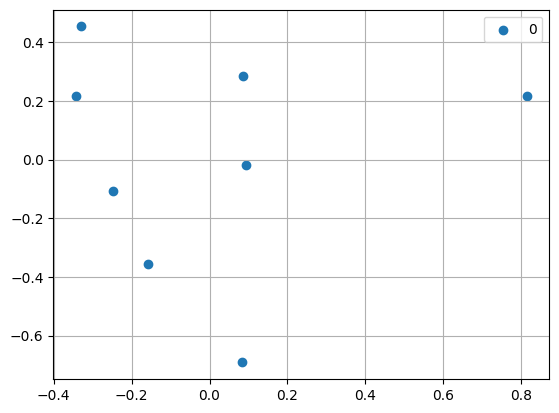

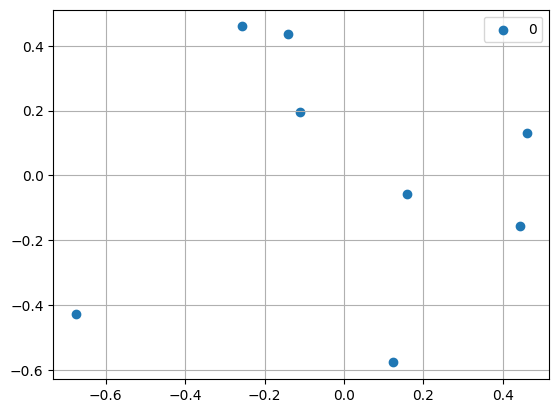

In [9]:
#torch.concat( (torch.stack((weights, weights)), weights.unsqueeze(-1).T))
#with torch.no_grad():
#    display(weights.unsqueeze(-1).T.shape)
fig, ax = plt.subplots()
for key in epoch_tracker:
    with torch.no_grad():
        U,S,V = torch.pca_lowrank(epoch_tracker[key], center=True, q=2)
        U=U.detach().cpu().numpy()
        ax.scatter(U.T[0], U.T[1], label=key)
ax.legend()
ax.grid(True)
plt.show()

fig2, ax2 = plt.subplots()
for key in last_weight:
    with torch.no_grad():
        U,S,V = torch.pca_lowrank(last_weight[key], center=True, q=2)
        U=U.detach().cpu().numpy()
        ax2.scatter(U.T[0], U.T[1], label=key)
ax2.legend()
ax2.grid(True)
plt.show()

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>], dtype=object)

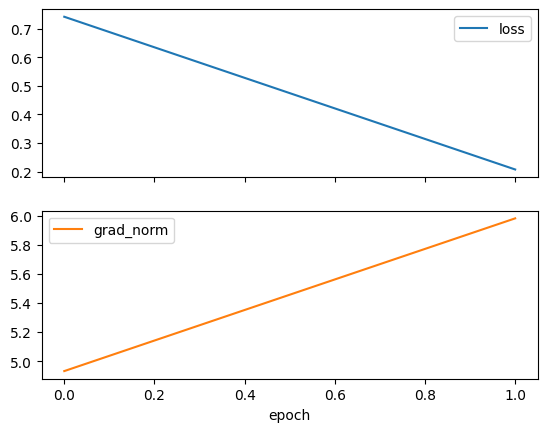

In [12]:
df.plot(x='epoch', y=['loss','grad_norm'], subplots=True)